# Une procédure complète de Machine Learning en Python: deuxième partie

Dans le premier post , nous avons nettoyé et structuré les données, par fORMED une analyse exploratoire des données, mis au point un ensemble de feature à utiliser dans notre modèle, et établi une base sur laquelle nous pouvons mesurer le rendement. Dans cet article, nous verrons comment implémenter et comparer plusieurs modèles de machine learning en Python, effectuer le réglage des hyperparamètres pour optimiser le meilleur modèle et évaluer le modèle final sur l'ensemble de test.

### Imports
Nous allons utilisé dans ce project les librairie standard de la data science et du machine learning 

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
#from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#### Read in Data
Premièrement chargeons les données précedente du partie 1

In [2]:
# Read in data into dataframes
train_features = pd.read_csv('C:/Users/Sony/Desktop/Mes_Docs/DA_DS/training_features.csv')
test_features = pd.read_csv('C:/Users/Sony/Desktop/Mes_Docs/DA_DS/testing_features.csv')
train_labels = pd.read_csv('C:/Users/Sony/Desktop/Mes_Docs/DA_DS/training_labels.csv')
test_labels = pd.read_csv('C:/Users/Sony/Desktop/Mes_Docs/DA_DS/testing_labels.csv')

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6748, 67)
Testing Feature Size:   (2893, 67)
Training Labels Size:   (6748, 1)
Testing Labels Size:    (2893, 1)


In [3]:
train_features.head(12)

,Order,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Property GFA - Self-Reported (ft²),log_Order,log_Largest Property Use Type - Gross Floor Area (ft²),log_Year Built,log_Property GFA - Self-Reported (ft²),Borough_Bronx,Borough_Brooklyn,Borough_Manhattan,Borough_Multifamily Housing,Borough_Queens,Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Ambulatory Surgical Center,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Courthouse,Largest Property Use Type_Data Center,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Food Service,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Laboratory,...,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Office,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Other - Technology/Science,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,11115.0,88212.0,1931.0,88212.0,9.316051,11.387498,7.565793,11.387498,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10779.0,120601.0,2004.0,120601.0,9.285355,11.700243,7.602900,11.700243,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5845.0,114314.0,1917.0,120334.0,8.673342,11.646704,7.558517,11.698026,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4907.0,176000.0,1966.0,176000.0,8.498418,12.078239,7.583756,12.078239,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8291.0,70030.0,1939.0,70030.0,9.022926,11.156679,7.569928,11.156679,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6509.0,84351.0,2006.0,84351.0,8.780941,11.342742,7.603898,11.342742,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,3747.0,353275.0,1986.0,370441.0,8.228711,12.775002,7.593878,12.822449,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,8842.0,111194.0,2006.0,111194.0,9.087268,11.619032,7.603898,11.619032,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12450.0,300000.0,1968.0,300000.0,9.429476,12.611538,7.584773,12.611538

The score column contains the Energy Star Score, the target for our machine learning problem. The Energy Star Score is supposed to be a comparitive measurement of the energy efficiency of a building, although we saw there may be issues with how this is calculated in part one!

Here's the distribution of the Energy Star Score.

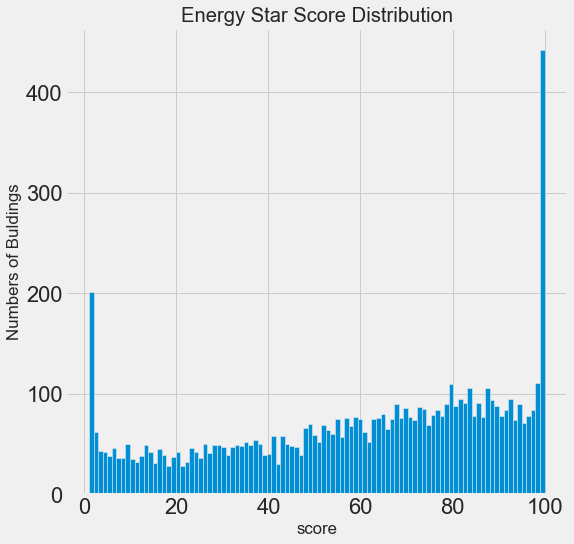

In [4]:
figsize(8,8)

# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train_labels['score'].dropna(), bins=100)
plt.xlabel('score')
plt.ylabel('Numbers of Buldings')
plt.title('Energy Star Score Distribution')
plt.show()

## Evaluating and Comparing Machine Learning Models
In this section we will build, train, and evalute several machine learning methods for our supervised regression task. The objective is to determine which model holds the most promise for further development (such as hyperparameter tuning).

We are comparing models using the mean absolute error. A baseline model that guessed the median value of the score was off by an average of 25 points.

#### Imputing Missing Values
Standard machine learning models cannot deal with missing values, and which means we have to find a way to fill these in or disard any features with missing values. Since we already removed features with more than 50% missing values in the first part, here we will focus on filling in these missing values, a process known as imputation). There are a number of methods for imputation but here we will use the relatively simple method of replacing missing values with the median of the column.  
  
In the code below, we create a Scikit-learn Imputer object to fill in missing values with the median of the column. Notice that we train the imputer (using the Imputer.fit method) on the training data but not the testing data. We then transform (using Imputer.transform) both the training data and testing data. This means that the missing values in the testing set are filled in with the median value of the corresponding columns in the training set. We have to do it this way rather than because at deployment time, we will have to impute the missing values in new observations based on the previous training data. This is one way to avoid the problem known as data leakage where information from the testing set "leaks" into the training process.

Bien que nous ayons supprimé les colonnes avec plus de 50% de valeurs manquantes lorsque nous avons nettoyé les données, il reste encore quelques observations manquantes. Les modèles d'apprentissage automatique ne peuvent pas gérer les valeurs absentes, nous devons donc les remplir, un processus appelé imputation .

Chaque valeur NaNreprésente une observation manquante. Bien qu'il existe plusieurs façons de remplir les données manquantes , nous utiliserons une méthode relativement simple, l'imputation médiane. Cela remplace toutes les valeurs manquantes dans une colonne par la valeur médiane de la colonne.

In [5]:
#from sklearn.preprocessing import Imputer

# Create an imputer object with a median filling strategy
#imputer = Imputer(strategy='median')
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Train on the training fetures
imputer.fit(train_features)

# Transform both training data and testing data

X = imputer.transform(train_features)
X_test = imputer.transform(test_features)


print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [6]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


After imputation, all of the features are real-valued.

#### Normaliser les features
La normalisation fait référence au processus général de modification de la plage d'une fonction. Cela est nécessaire car les caractéristiques sont mesurées dans différentes unités et couvrent donc différentes plages. Les méthodes telles que les SVM et les K plus proches voisins qui prennent en compte les mesures de distance entre les observations sont significativement affectées par la gamme des caractéristiques et la mise à l'échelle leur permet d'apprendre. Bien que des méthodes telles que la régression linéaire et la Random Forest ne nécessitent pas réellement de mise à l'échelle des fonctionnalités, il est toujours recommandé de suivre cette étape lorsque nous comparons plusieurs algorithmes.  
  
There are two ways to scale features:

1. For each value, subtract the mean of the feature and divide by the standard deviation of the feature. This is known as standardization and results in each feature having a mean of 0 and a standard deviation of 1.
2. For each value, subtract the minimum value of the feature and divide by the maximum minus the minimum for the feature (the range). This assures that all the values for a feature are between 0 and 1 and is called scaling to a range or normalization.  
  
As with imputation, when we train the scaling object, we want to use only the training set. When we transform features, we will transform both the training set and the testing set.

In [7]:
from sklearn.preprocessing import MinMaxScaler
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1,))

#### Models to Evaluate
Nous évaluerons cinq modèles différents couvrant le spectre de complexité:  
1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression  
  
Dans cet article, nous nous concentrerons sur la mise en œuvre de ces méthodes plutôt que sur la théorie qui les sous-tend.

Après tout le travail que nous avons consacré au nettoyage et au formatage des données, la création, la formation et la prédiction avec les modèles sont relativement simples. Nous utiliserons la bibliothèque Scikit-Learn en Python, qui possède une excellente documentation et une syntaxe de construction de modèle cohérente. Une fois que vous savez comment créer un modèle dans Scikit-Learn, vous pouvez rapidement implémenter une gamme diversifiée d'algorithmes.  

Nous pouvons illustrer un exemple de création de modèle, d'entraînement (utilisation .fit) et de test (utilisation .predict) avec le Gradient Boosting Regressor:

In [8]:
# Function to calculate MAE
def mae(y_true, y_pred):
    return np.mean(abs(y_true-y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    #Train the model
    model.fit(X,y)
    
    # Make predictions and evaluate
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # return the performance metric
    return model_mae

In [9]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 24.7931


In [10]:
svm = SVR(C=1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE=%0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE=23.7607


In [11]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE=%0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE=23.3050


In [12]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE=%0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE=23.6895


In [13]:
Knn = KNeighborsRegressor(n_neighbors=10)
Knn_mae = fit_and_evaluate(Knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE=%0.4f' % Knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE=23.8563


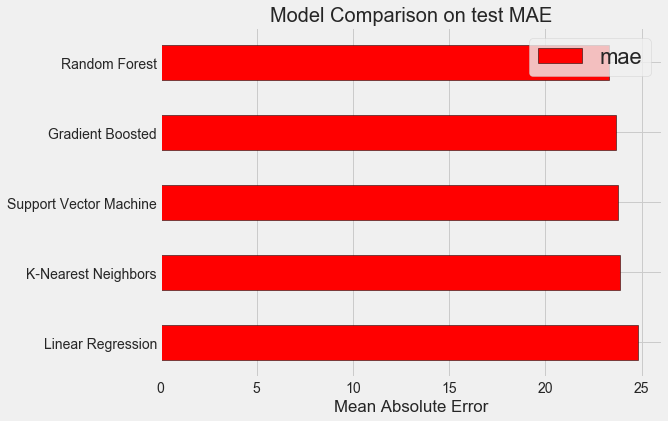

In [14]:
plt.style.use('fivethirtyeight')
figsize(8,6)

# DataFrame to hold the results
model_comparison = pd.DataFrame({'model':['Linear Regression', 'Support Vector Machine', 'Random Forest', 'Gradient Boosted', 'K-Nearest Neighbors'], 'mae':[lr_mae, svm_mae, random_forest_mae, gradient_boosted_mae, Knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending=False).plot(x='model', y='mae', kind='barh',color = 'red', edgecolor = 'black')

# plot formatting
plt.ylabel('')
plt.yticks(size=14)
plt.xlabel('Mean Absolute Error')
plt.xticks(size=14)
plt.title('Model Comparison on test MAE', size=20)
plt.show()

Le **régresseur Random Forest**(MAE=23.3050) bat légèrement la **Grandient Boosted**(MAE=23.6895). Ces résultats ne sont pas tout à fait équitables car nous utilisons principalement les valeurs par défaut pour les hyperparamètres. *Surtout dans les modèles tels que la Support Vector Machine*, les performances dépendent fortement de ces paramètres. Néanmoins, à partir de ces résultats, nous sélectionnerons le régresseur Gradient Boosted pour l'optimisation du modèle.

#### Réglage des hyperparamètres pour l'optimisation du modèle
En Machine Learning, après avoir sélectionné un modèle, nous pouvons l'optimiser pour notre problème en réglant les hyperparamètres du modèle.  
  
Tout d'abord, que sont les hyperparamètres et en quoi diffèrent-ils des paramètres ?  
* Les **hyperparamètres** de modèle sont mieux considérés comme des paramètres pour un algorithme de machine learning qui sont définis par le datascientist avant l'entraînement. Des exemples seraient le nombre d'arbres dans une Random Forest ou le nombre de voisins utilisés dans l'algorithme des K voisins les plus proches.  
* Les **paramètres** du modèle sont ce que le modèle apprend pendant l'entraînement, comme les pondérations dans une régression linéaire.  
  



##### Recherche aléatoire avec validation croisée
La méthode de réglage des hyperparamètres que nous allons implémenter est appelée recherche aléatoire avec validation croisée:  
* **La recherche aléatoire** fait référence à la technique que nous utiliserons pour sélectionner les hyperparamètres. Nous définissons une grille puis échantillonnons au hasard différentes combinaisons, plutôt qu'une recherche de grille où nous essayons de manière exhaustive chaque combinaison.  
* **La validation croisée** est la technique que nous utilisons pour évaluer une combinaison sélectionnée d'hyperparamètres. Plutôt que de diviser la configuration de la formation en ensembles de formation et de validation séparés, ce qui réduit la quantité de données de formation que nous pouvons utiliser, nous utilisons la validation croisée K-Fold. Cela implique de diviser les données d'entraînement en K nombre de plis, puis de passer par un processus itératif où nous nous entraînons d'abord sur K-1 des plis, puis évaluons les performances sur le Kème pli. Nous répétons ce processus K fois et à la fin de la validation croisée du facteur K, nous prenons l'erreur moyenne sur chacune des K itérations comme mesure de performance finale.


Here we will implement random search with cross validation to select the optimal hyperparameters for the gradient boosting regressor. We first define a grid then peform an iterative process of: randomly sample a set of hyperparameters from the grid, evaluate the hyperparameters using 4-fold cross-validation, and then select the hyperparameters with the best performance.

Of course we don't actually do this iteration ourselves, we let Scikit-Learn and `RandomizedSearchCV` do the process for us!

In [15]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of tree used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2,3,5,10,15]

# Minimum number of sample per leaf
min_samples_leaf = [1,2,4,6,8]

# Minimum number of samples to split a node
min_samples_split = [2,4,6,10]

# Maximum number of features to consider for making splits 
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss':loss,
                      'n_estimators': n_estimators,
                       'max_depth':max_depth,
                      'min_samples_leaf': min_samples_leaf,
                      'min_samples_split': min_samples_split,
                      'max_features': max_features}

Nous optimiserons les hyperparamètres suivants:  

* `loss`: la fonction de perte pour minimiser  

* `n_estimators`: le nombre d'apprenants faibles (arbres de décision) à utiliser  

* `max_depth`: la profondeur maximale de chaque arbre de décision  

* `min_samples_leaf`: le nombre minimum d'exemples requis à un nœud feuille de l'arbre de décision  

* `min_samples_split`: le nombre minimum d'exemples requis pour scinder un nœud de l'arbre de décision  

* `max_features`: le nombre maximum d'entités à utiliser pour la division des nœuds

The Randomized Search Object is trained the same way as any other scikit-learn model. After training, we can compare all the different hyperparameter combinations and find the best performing one.

In [16]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state=42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model, 
                              param_distributions=hyperparameter_grid, 
                              cv=4, n_iter=25, scoring='neg_mean_absolute_error', 
                              n_jobs=-1, verbose=1, return_train_score=True, 
                              random_state=42)

In [ ]:
# fit on the training data
random_cv.fit(X,y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Scikit-learn uses the negative mean absolute error for evaluation because it wants a metric to maximize. Therefore, a better score will be closer to 0. We can get the results of the randomized search into a dataframe, and sort the values by performance.

In [ ]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending=False)

random_results.head(10)

In [ ]:
random_cv.best_estimator_

The best gradient boosted model has the following hyperparameters:

loss = huber  

n_estimators = 100  

max_depth = 10  

min_samples_leaf = 8  

min_samples_split = 6  

max_features = sqrt 

Here we will use grid search with a grid that only has the n_estimators hyperparameter. We will evaluate a range of trees then plot the training and testing performance to get an idea of what increasing the number of trees does for our model. We will fix the other hyperparameters at the best values returned from random search to isolate the number of trees effect.

In [ ]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [100,150,200,250,300,350,400,450,
                              500,550,600,650,700,750,800]}
model = GradientBoostingRegressor(loss='huber', max_depth=10, 
                                 min_samples_leaf = 8,
                                 min_samples_split = 6,
                                 max_features = 'sqrt',
                                 random_state=42)

# Grid Search Object Using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid = trees_grid, cv = 4,
                          scoring = 'neg_mean_absolute_error', verbose=1, n_jobs = -1, return_train_score = True)

In [ ]:
# Fit the grig search
grid_search.fit(X, y)

In [ ]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8,8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1*results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1*results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Performance vs Number of Trees')

À mesure que le nombre d'arbres utilisés par le modèle augmente, la formation et l'erreur de test auguemente. Cependant, l'erreur d'apprentissage diminue beaucoup plus rapidement et nous pouvons voir que notre modèle est surajusté: il fonctionne très bien sur les données d'entraînement, mais n'est pas capable d'atteindre les mêmes performances sur l'ensemble de test.  
  
Nous nous attendons toujours à au moins une certaine diminution des performances sur l'ensemble de test (après tout, le modèle peut voir les vraies réponses pour l'ensemble d'entraînement), mais un écart important indique un surajustement . Nous pouvons résoudre le problème de surajustement en obtenant plus de données d'entraînement ou en réduisant la complexité de notre modèle grâce aux hyerparamètres . Dans ce cas, nous laisserons les hyperparamètres là où ils sont, mais j'encourage tout le monde à essayer de réduire le surajustement.

In [ ]:
results.sort_values('mean_test_score', ascending = False).head(5)

Pour le modèle final, nous utiliserons 100 estimateurs, car cela a entraîné la plus faible erreur de validation croisée. Maintenant, il est temps de tester ce modèle!

### Evaluate Final Model on the Test Set

We will use the best model from hyperparameter tuning to make predictions on the testing set. Remember, our model has never seen the test set before, so this performance should be a good indicator of how the model would perform if deployed in the real world.

For comparison, we can also look at the performance of the default model. The code below creates the final model, trains it (with timing), and evaluates on the test set.

In [ ]:
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

In [ ]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

In [ ]:
%%timeit -n 1 -r 5
final_model.fit(X,y)

In [ ]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print("Default model performance on the test set: MAE=%0.4f." % mae(y_test, default_pred))
print("Final model performance on the test set: MAE=%0.4f." % mae(y_test, final_pred))

Le réglage des hyperparamètres a amélioré la précision du modèle d'environ 6%. Selon le cas d'utilisation, 6% pourrait être une amélioration massive, mais cela s'est traduit par un investissement en temps important(3.7 time sur ma machine)!


* To get a sense of the predictions, we can plot the distribution of true values on the test set and the predicted values on the test set.

In [ ]:
figsize(8,8)

# Density plot of the final prediction and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score')
plt.ylabel('Density')
plt.title('Test Values and Predictions')
plt.show()

The distribution looks to be nearly the same although the density of the predicted values is closer to the median of the test values rather than to the actual peak at 100. It appears the model might be less accurate at predicting the extreme values and instead predicts values closer to the median

Another diagnostic plot is a histogram of the residuals. Ideally, we would hope that the residuals are normally distributed, meaning that the model is wrong the same amount in both directions (high and low).

In [ ]:
figsize = (6,6)

# Calculate the residuals
residuals = final_pred-y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20, edgecolor = 'black')
plt.xlabel('Error')
plt.ylabel('Count')
plt.title('Distribution of Residuals')

Les prédictions du modèle semblent suivre la distribution des valeurs réelles bien que le pic de densité se situe plus près de la valeur médiane (66) sur l'ensemble d'apprentissage que du véritable pic de densité (qui est proche de 100). Les résidus sont presque normalement une distribution, bien que nous voyions quelques grandes valeurs négatives où les prédictions du modèle étaient bien inférieures aux valeurs réelles

Les résultats de ce travail nous ont montré que l'apprentissage automatique est applicable à la tâche de prédire le score Energy Star d'un bâtiment à l'aide des données disponibles. En utilisant un régresseur amplifié par gradient, nous avons pu prédire les scores de l'ensemble de test à 6 points près de la valeur réelle. De plus, nous avons vu que le réglage des hyperparamètres peut augmenter les performances d'un modèle à un coût important en termes de temps investi. C'est l'un des nombreux compromis à prendre en compte lors du développement d'une solution d'apprentissage automatique.